## ...Import Libraries & Load Data...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'C:/Users/ukwun/Documents/DS_Projects/o_datasets/pfreres_champagne.csv')

In [5]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


## ...Data Preprocessing...

In [6]:
df.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [7]:
df.tail(4)

,Month,Perrin Freres monthly champagne sales millions ?64-?72
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [8]:
df.shape

(107, 2)

In [9]:
df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'sales'}, inplace=True)

In [10]:
df.drop([105, 106], inplace=True)

In [ ]:
# Check for missing dates and fill with zero sales values

In [11]:
df = df.groupby('Month')['sales'].sum().reset_index()

missing_dates = pd.date_range(start=df['Month'].min(), 
                              end=df['Month'].max()).difference(df['Month'])

In [12]:
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['1964-01-01', '1964-01-02', '1964-01-03', '1964-01-04',
               '1964-01-05', '1964-01-06', '1964-01-07', '1964-01-08',
               '1964-01-09', '1964-01-10',
               ...
               '1972-08-23', '1972-08-24', '1972-08-25', '1972-08-26',
               '1972-08-27', '1972-08-28', '1972-08-29', '1972-08-30',
               '1972-08-31', '1972-09-01'],
              dtype='datetime64[ns]', length=3167, freq='D')


In [13]:
'''
To achieve a continuous time period, we need to fill in missing dates with zero sales values.
However, filling in 3167 missing dates will significantly inflate the size.
Therefore, we'll use the 'Interpolation' techniques to estimate values between existing data points.

'''

"\nTo achieve a continuous time period, we need to fill in missing dates with zero sales values.\nHowever, filling in 3167 missing dates will significantly inflate the size.\nTherefore, we'll use the 'Interpolation' techniques to estimate values between existing data points.\n\n"

## ...Interpolation Technique...

In [14]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

In [15]:
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
df_reindexed = df.reindex(full_date_range)
data = df_reindexed.interpolate(method='linear')
data['sales'].fillna(0, inplace=True)

In [16]:
data.head()

,sales
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [17]:
data.shape

(105, 1)

## ...Data Visualization...

In [18]:
data.describe()

,sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [ ]:
# Monthly Sales Trends

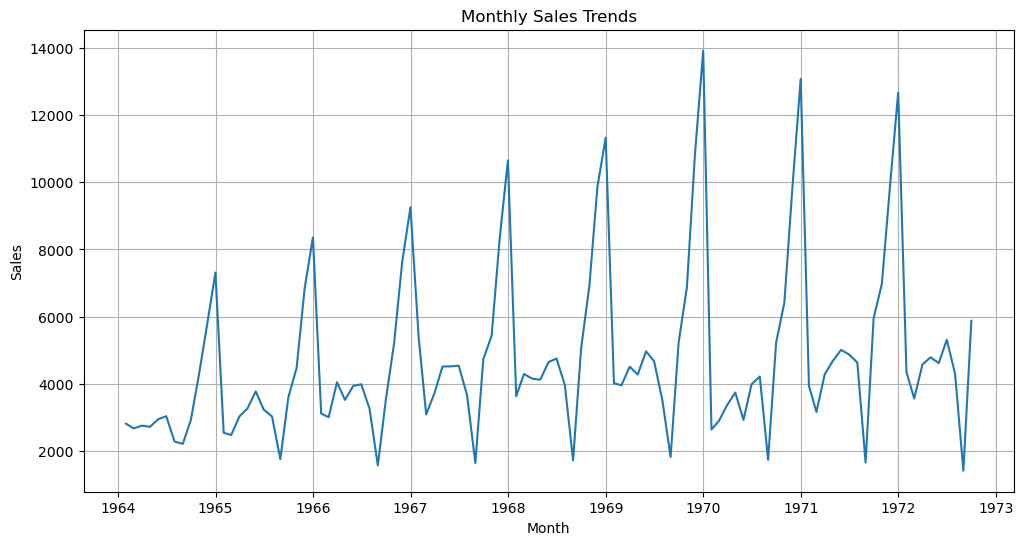

In [19]:
monthly_sales = data.resample('M').sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['sales'])
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [ ]:
# Quarterly Sales Trends

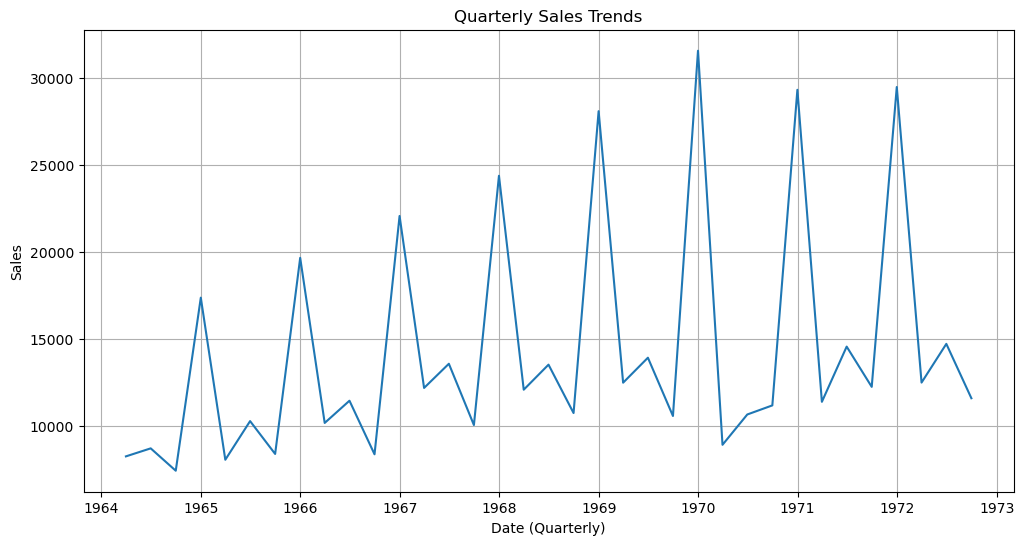

In [20]:
quarterly_sales = data.resample('Q').sum()

plt.figure(figsize=(12, 6))
plt.plot(quarterly_sales.index, quarterly_sales['sales'])
plt.title('Quarterly Sales Trends')
plt.xlabel('Date (Quarterly)')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [21]:
'''
From both graphs above, it's clear that the time series data follows a seasonal pattern.
We need to test for 'Stationarity' before feeding it to the machine learning algorithm.
Suppose the data is not stationary, we'll use a differencing analysis to make it stationary
'''

"\nFrom both graphs above, it's clear that the time series data follows a seasonal pattern.\nWe need to test for 'Stationarity' before feeding it to the machine learning algorithm.\nSuppose the data is not stationary, we'll use a differencing analysis to make it stationary\n"

## ...Stationarity Check...

In [ ]:
# Augmented Dickey-Fuller (ADF)

In [22]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF test statistics', 'p-value', 'Lags used', 'Number of obs used']
    for value, label in zip(result, labels):
        print('{}: {:.4f}'.format(label, value))
    
    critical_values = result[4]
    print('\nCritical Values:')
    for key, value in critical_values.items():
        print('\t{}%: {:.3f}'.format(key, value))
    
    if result[1] <= 0.05:
        print('\nThe p-value is less than or equal to 0.05.')
        print('Strong evidence against the null hypothesis.')
        print('Reject the null hypothesis.')
        print('Conclusion: The data is stationary.')
    else:
        print('\nThe p-value is greater than 0.05.')
        print('Weak evidence against the null hypothesis.')
        print('Accept the null hypothesis.')
        print('Conclusion: The data is not stationary.')

In [23]:
# Monthly sales

adfuller_test(monthly_sales['sales'])

ADF test statistics: -1.8336
p-value: 0.3639
Lags used: 11.0000
Number of obs used: 93.0000

Critical Values:
	1%%: -3.503
	5%%: -2.893
	10%%: -2.584

The p-value is greater than 0.05.
Weak evidence against the null hypothesis.
Accept the null hypothesis.
Conclusion: The data is not stationary.


In [24]:
# Quarterly sales

adfuller_test(quarterly_sales['sales'])

ADF test statistics: -1.6876
p-value: 0.4375
Lags used: 3.0000
Number of obs used: 31.0000

Critical Values:
	1%%: -3.661
	5%%: -2.961
	10%%: -2.619

The p-value is greater than 0.05.
Weak evidence against the null hypothesis.
Accept the null hypothesis.
Conclusion: The data is not stationary.


In [25]:
'''
Here, both Monthly and Quarterly sales do not show data stationarity.
Therefore,'Differencing' technique is required
'''

"\nHere, both Monthly and Quarterly sales do not show data stationarity.\nTherefore,'Differencing' technique is required\n"

## ...Defferencing...

In [ ]:
# monthly first-order differencing 

In [26]:
monthly_sales['1st_order_diff.'] = monthly_sales['sales'] - monthly_sales['sales'].shift(12)
adfuller_test(monthly_sales['1st_order_diff.'].dropna())

ADF test statistics: -7.6266
p-value: 0.0000
Lags used: 0.0000
Number of obs used: 92.0000

Critical Values:
	1%%: -3.504
	5%%: -2.894
	10%%: -2.584

The p-value is less than or equal to 0.05.
Strong evidence against the null hypothesis.
Reject the null hypothesis.
Conclusion: The data is stationary.


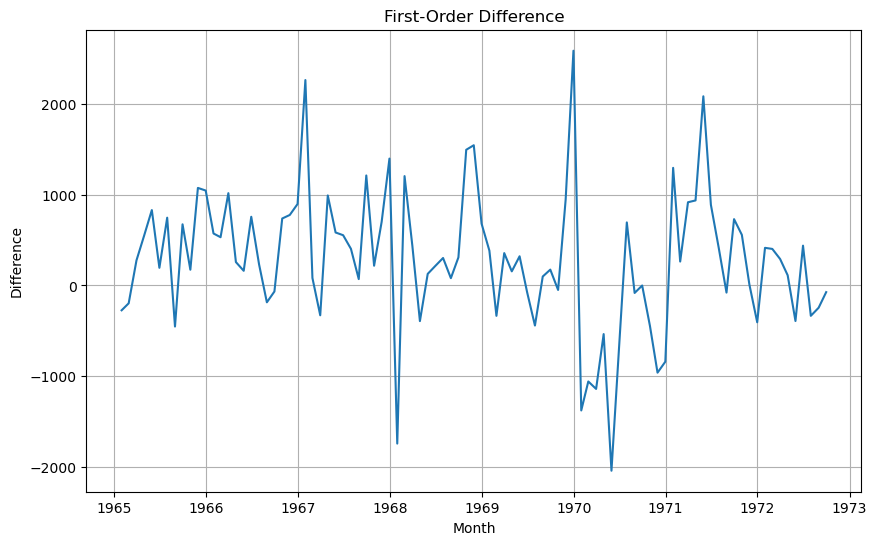

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['1st_order_diff.'])
plt.title('First-Order Difference')
plt.xlabel('Month')
plt.ylabel('Difference')
plt.grid(True)
plt.show()

## ...ACF & PACF Plot...

In [ ]:
# Determine p and q values

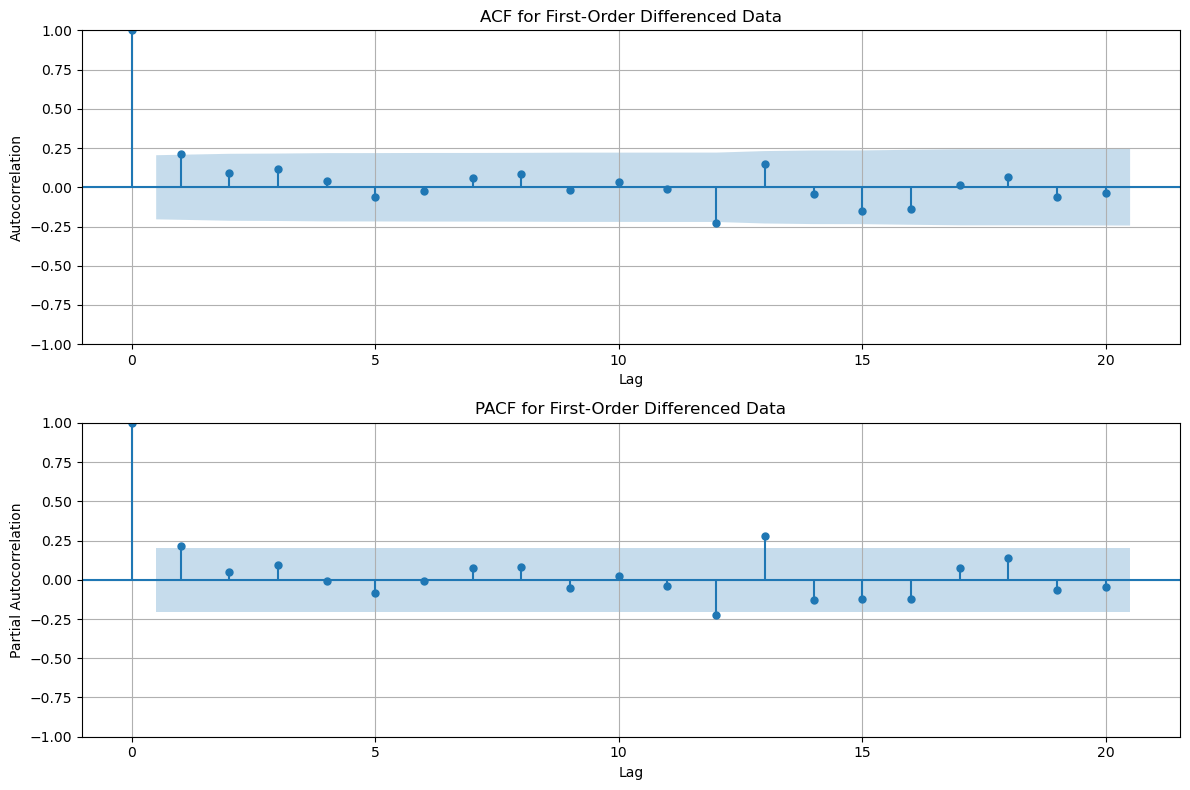

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(monthly_sales['1st_order_diff.'].iloc[13:], lags=20, ax=ax1)
ax1.set_title('ACF for First-Order Differenced Data')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.grid(True)

plot_pacf(monthly_sales['1st_order_diff.'].iloc[13:], lags=20, ax=ax2)
ax2.set_title('PACF for First-Order Differenced Data')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')
ax2.grid(True)

plt.tight_layout()
plt.show()

## ...Sales Forecasting...

#### ARIMA model

In [29]:
arima_model = ARIMA(monthly_sales['sales'], order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Thu, 02 May 2024   AIC                           1911.627
Time:                        12:49:15   BIC                           1919.560
Sample:                    01-31-1964   HQIC                          1914.841
                         - 09-30-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.0

In [30]:
monthly_sales.shape

(105, 2)

In [ ]:
# ARIMA Sales Forecast

In [31]:
monthly_sales['ARIMA_forecast'] = arima_result.predict(start=90, end=104, dynamic=True)

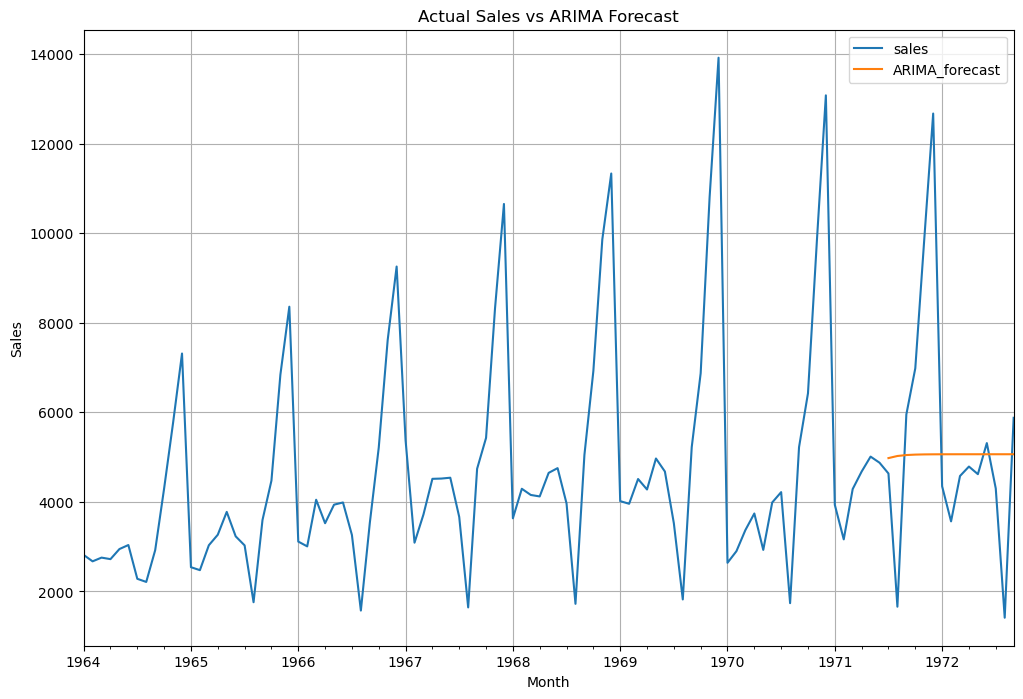

In [32]:
monthly_sales[['sales', 'ARIMA_forecast']].plot(figsize=(12,8))
plt.title('Actual Sales vs ARIMA Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [ ]:
# Forecasted Sales by ARIMA for the last 15 period(s)

In [33]:
monthly_sales.tail(15)

,sales,1st_order_diff.,ARIMA_forecast
1971-07-31,4633.0,416.0,4977.053232
1971-08-31,1659.0,-79.0,5023.890466
1971-09-30,5951.0,730.0,5045.177780
1971-10-31,6981.0,557.0,5054.852769
1971-11-30,9851.0,9.0,5059.250008
1971-12-31,12670.0,-406.0,5061.248534
1972-01-31,4348.0,414.0,5062.156855
1972-02-29,3564.0,402.0,5062.569683
1972-03-31,4577.0,291.0,5062.757311
1972-04-30,4788.0,112.0,5062.842588


#### SARIMA model

In [34]:
sarimax_model = SARIMAX(monthly_sales['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = sarimax_model.fit()
print(sarimax_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Thu, 02 May 2024   AIC                           1486.804
Time:                                    12:49:53   BIC                           1499.413
Sample:                                01-31-1964   HQIC                          1491.893
                                     - 09-30-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043   

In [ ]:
# SARIMA Sales Forecast

In [35]:
monthly_sales['SARIMA_forecast'] = sarimax_result.predict(start=90, end=104, dynamic=True)

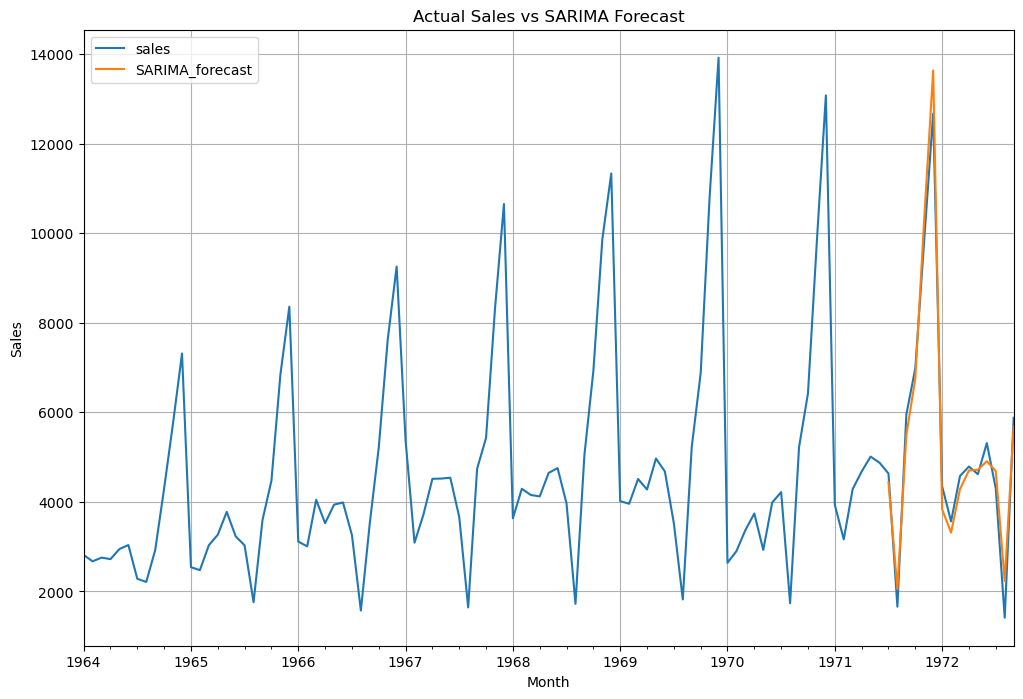

In [36]:
monthly_sales[['sales', 'SARIMA_forecast']].plot(figsize=(12,8))
plt.title('Actual Sales vs SARIMA Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

#### ARIMA Vs SARIMA Sales Forecasting Accuracy

In [61]:
monthly_sales.tail(20)

,sales,1st_order_diff.,ARIMA_forecast,SARIMA_forecast
1971-02-28,3162.0,263.0,NaN,NaN
1971-03-31,4286.0,916.0,NaN,NaN
1971-04-30,4676.0,936.0,NaN,NaN
1971-05-31,5010.0,2083.0,NaN,NaN
1971-06-30,4874.0,888.0,NaN,NaN
1971-07-31,4633.0,416.0,4977.053232,4437.325018
1971-08-31,1659.0,-79.0,5023.890466,2050.747693
1971-09-30,5951.0,730.0,5045.177780,5493.376617
1971-10-31,6981.0,557.0,5054.852769,6752.038831
1971-11-30,9851.0,9.0,5059.250008,10327.297239
